<a href="https://colab.research.google.com/github/vitorpohlenz/PPGMTM_UFSC/blob/main/Boston_Housing_VPZ_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [38]:
# Importando bibliotecas comuns
import numpy as np
import os
import pandas as pd
import copy
import seaborn as sns
import datetime
import re

#Stactic random seed for reproducibility
seed = 9 
np.random.seed(seed) 

# Layou dos plots
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', figsize = [12,10])

plt.style.use('ggplot')

import plotly.graph_objects as go
import plotly.express as px

# Warnings desnecessatios
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
warnings.filterwarnings(action="ignore", message=".*distplot")

# Machine Learning libraries
from sklearn.pipeline import (make_pipeline,Pipeline)
from sklearn import (preprocessing, decomposition)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (median_absolute_error,explained_variance_score,mean_squared_error)
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import f_regression, mutual_info_regression

## Regression
from sklearn import ensemble
from sklearn.linear_model import (
    LinearRegression, RANSACRegressor)

# Functions

In [59]:
def GetBestNTrees(x_train,y_train,x_val,y_val,estimator,min_trees,max_trees,step = 1,n_error_up = 5):
  """Function to find best number of trees with Early Stopping"""
  forest = copy.copy(estimator)
  forest.warm_start=True
  
  min_val_error = float("inf")
  error_going_up = 0
  val_error = 0
  n_best = 0

  for n_tree in np.arange(min_trees,max_trees+1,step):
      forest.n_estimators = n_tree
      forest.fit(x_train, y_train)
      val_error = median_absolute_error(y_true= y_val, y_pred= forest.predict(x_val))
      if val_error < min_val_error:
          min_val_error = val_error
          error_going_up = 0
          n_best = n_tree
          best_estimator = copy.copy(forest)
      else:
          error_going_up += 1
          if error_going_up == n_error_up:
              break  # early stopping 
              
              
  return [n_best,best_estimator]

# Import Data

In [3]:
#From sklearn tutorial.
from sklearn.datasets import load_boston
housing_boston = load_boston()
housing_boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [4]:
boston = pd.DataFrame(data = housing_boston['data'], columns=housing_boston['feature_names'])
boston['target'] = housing_boston['target']

In [5]:
print(housing_boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [6]:
boston.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'target'],
      dtype='object')

# Features and Targets

In [7]:
nm_features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
               'PTRATIO', 'B', 'LSTAT']
nm_targets = ['target']               

# Test Train Split

In [8]:
# Train+Validation and test
trainVal, test = train_test_split(boston,
                               test_size = 0.15, random_state = seed)
# Train and Validation(for use with warmstart in training)
train, validation = train_test_split(trainVal, 
                                     test_size = 0.2, random_state = seed)

# Exploring the Data

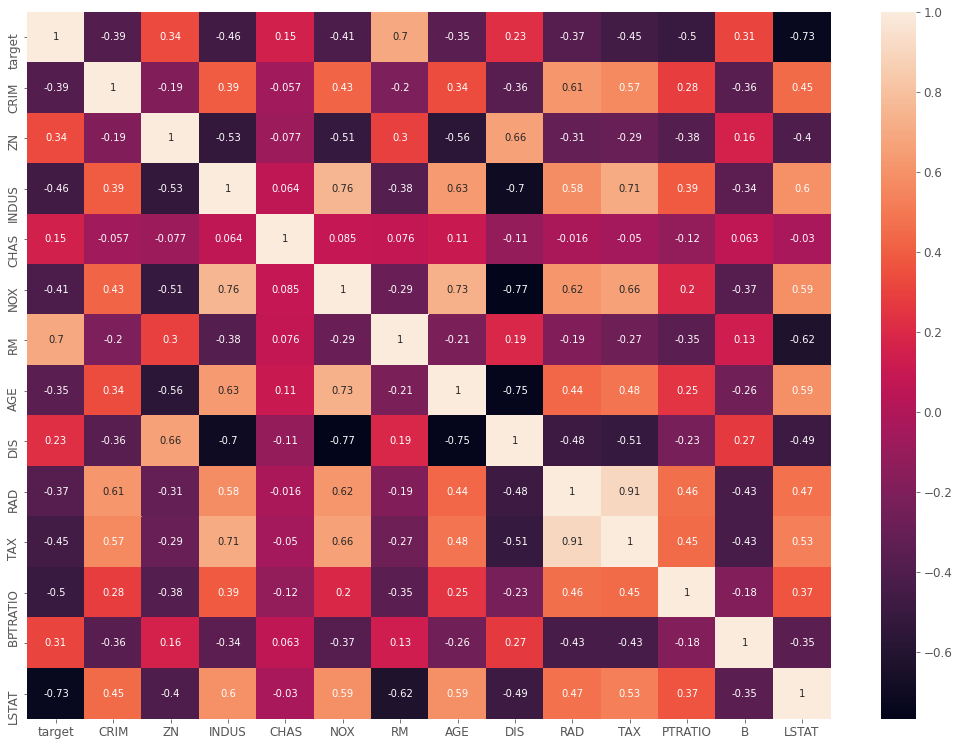

In [9]:
fig, ax = plt.subplots(figsize=(18,13))     
sns.heatmap(trainVal[nm_targets+nm_features].corr(), annot=True)

 Better correlation with target is the LSTAT feature.

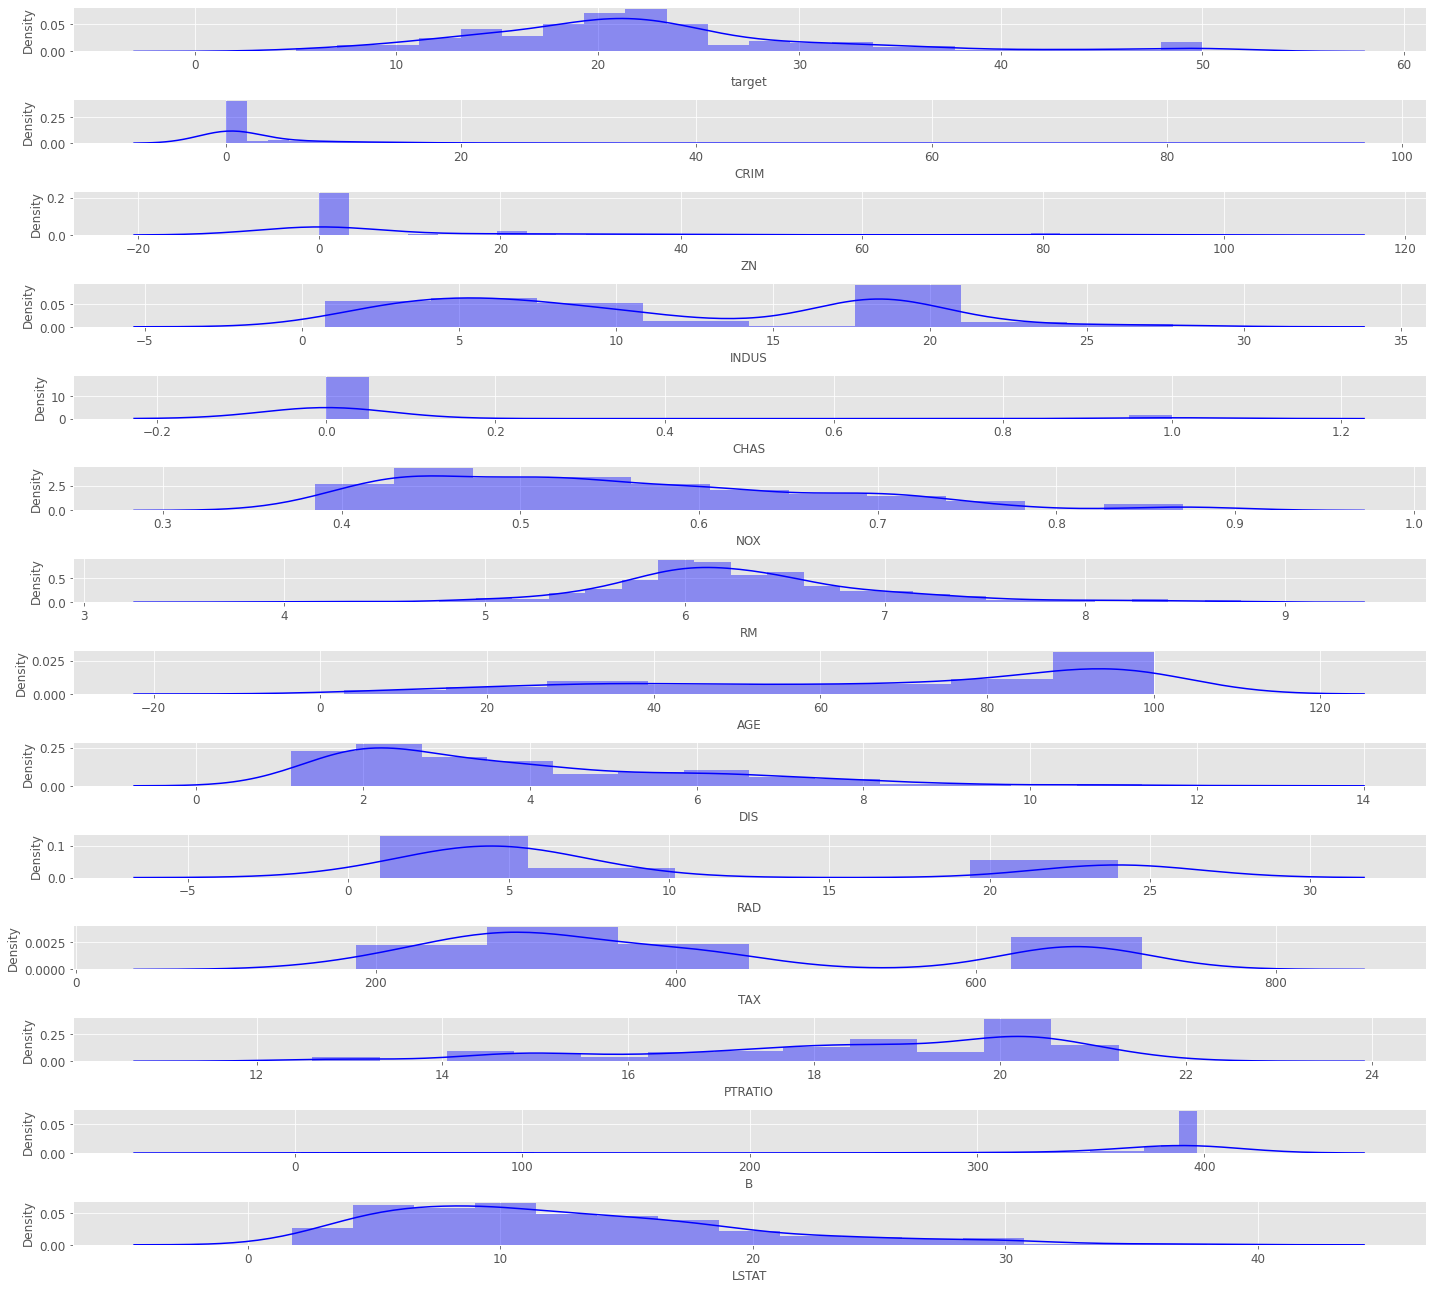

In [10]:
# Set up the matplotlib figure
f, axes = plt.subplots(len(nm_features+nm_targets), 1, sharex = False, figsize = (20,18))

k = 0
for nm in nm_targets+nm_features:
  # Plot a simple histogram with binsize determined automatically
  sns.distplot(trainVal[nm], color="b", ax=axes[k])
  k = k+1

plt.tight_layout()

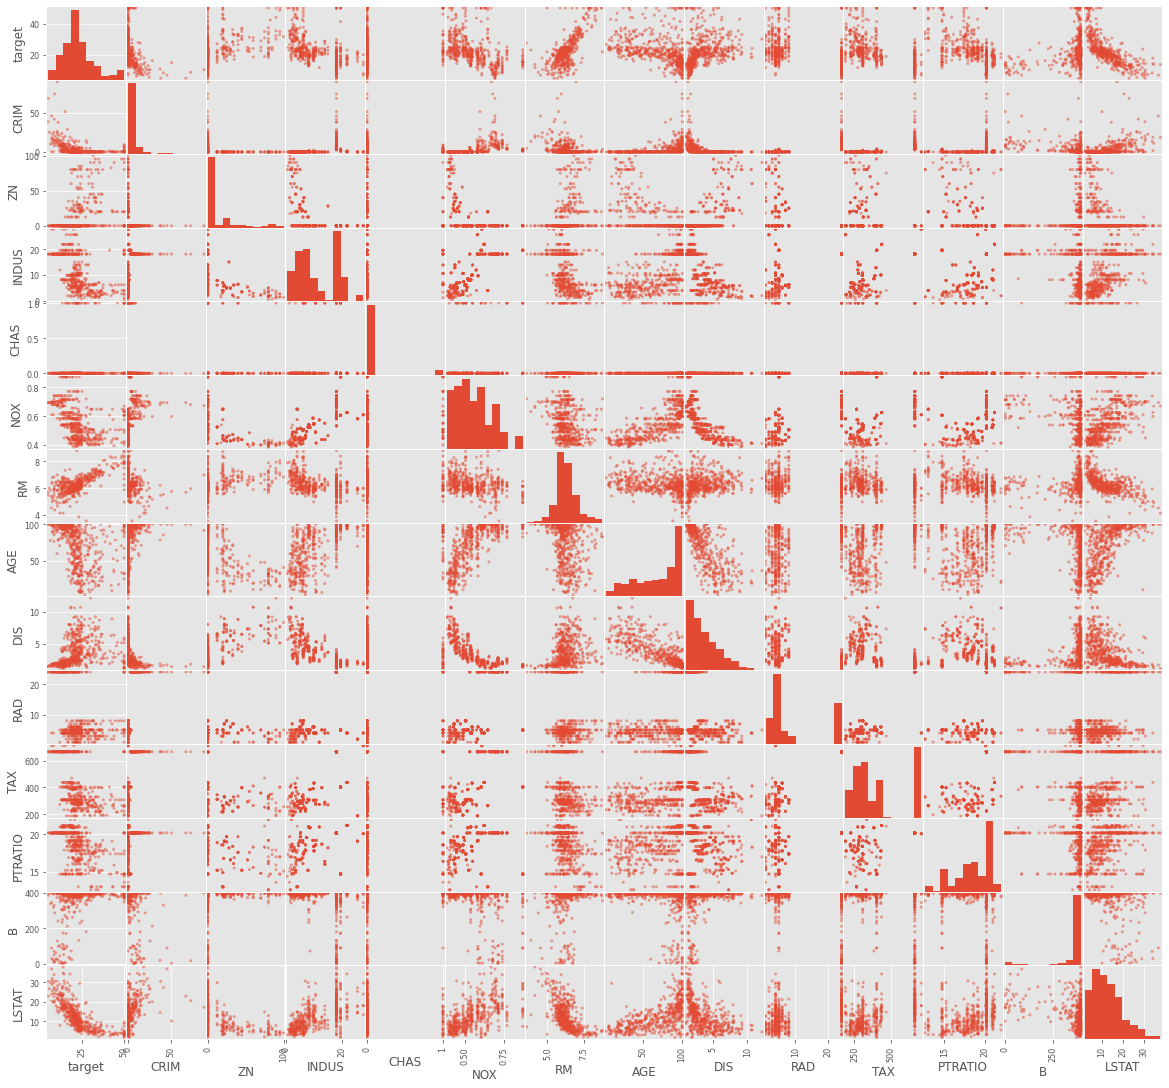

In [11]:
pd.plotting.scatter_matrix(boston[nm_targets+nm_features], figsize=(20, 19))
plt.show()

Mutual information and F-test for regression.
Implemented with the [example][1] of Scikit-Learn User Guide.

  [1]: https://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html

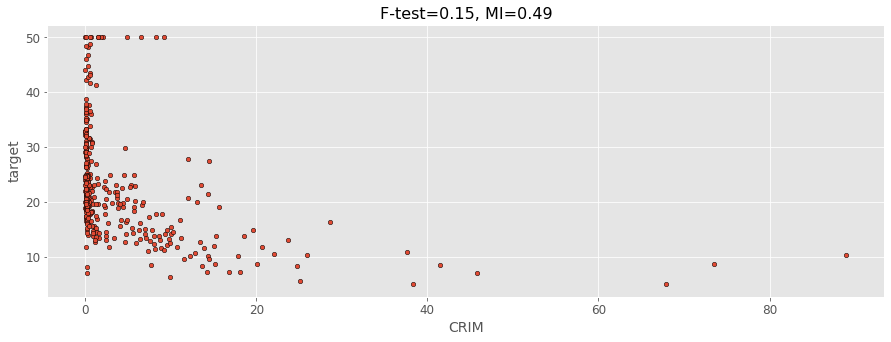

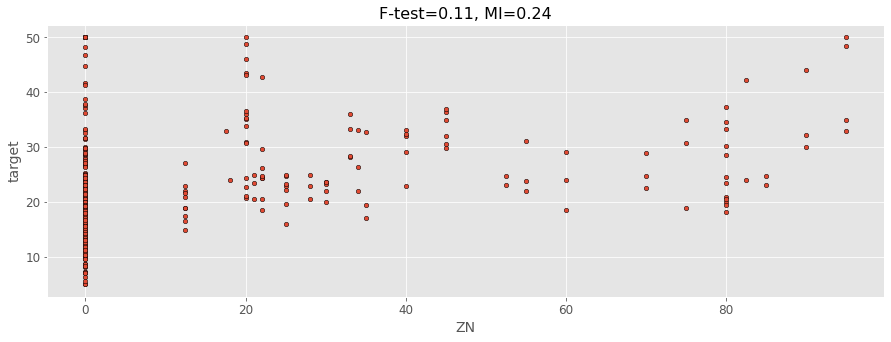

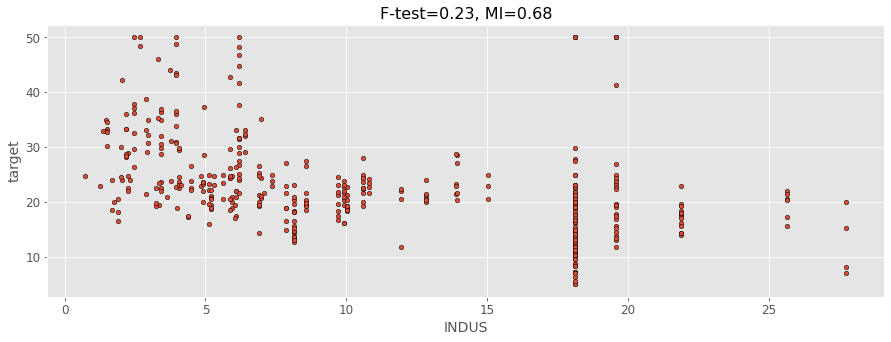

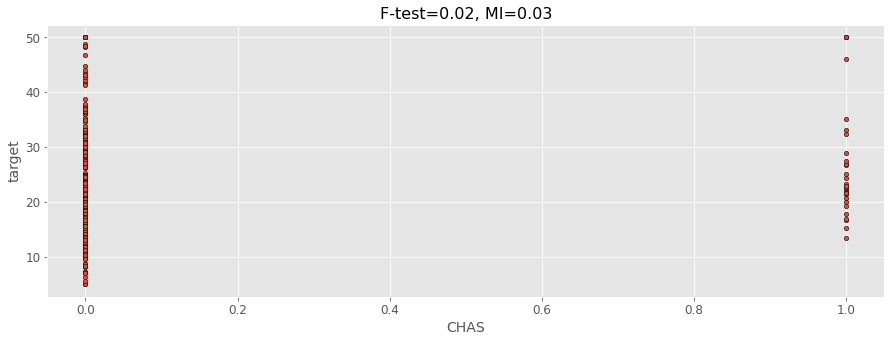

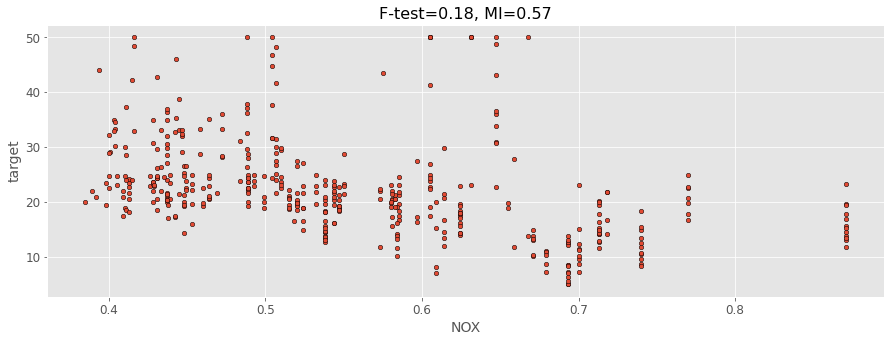

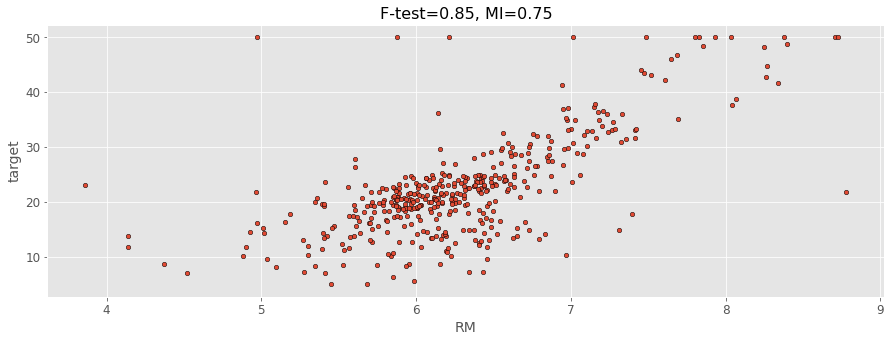

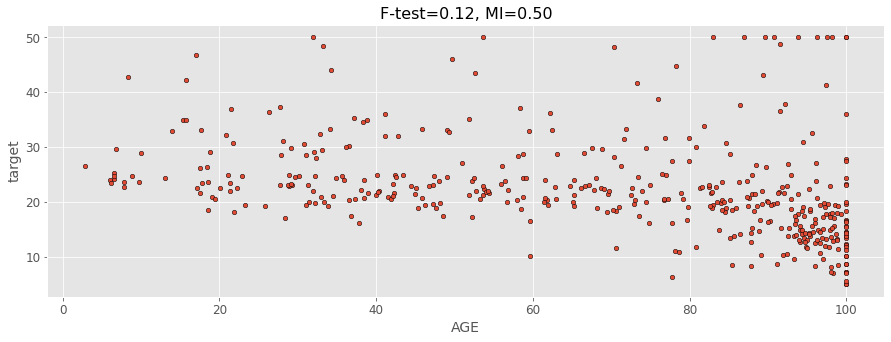

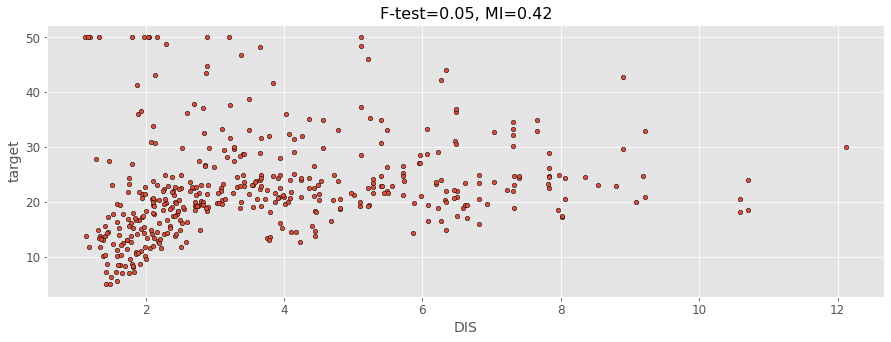

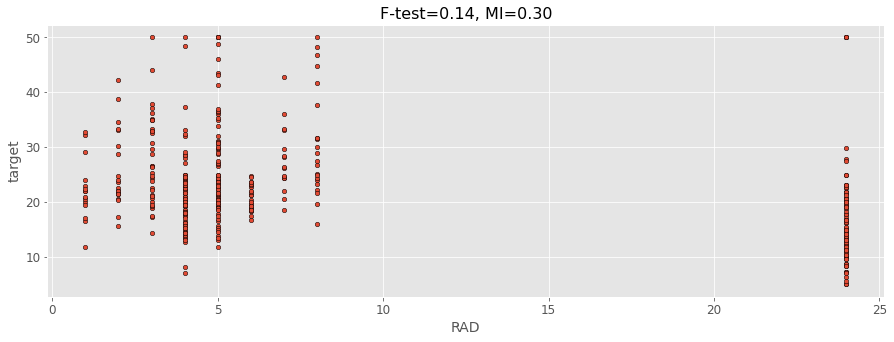

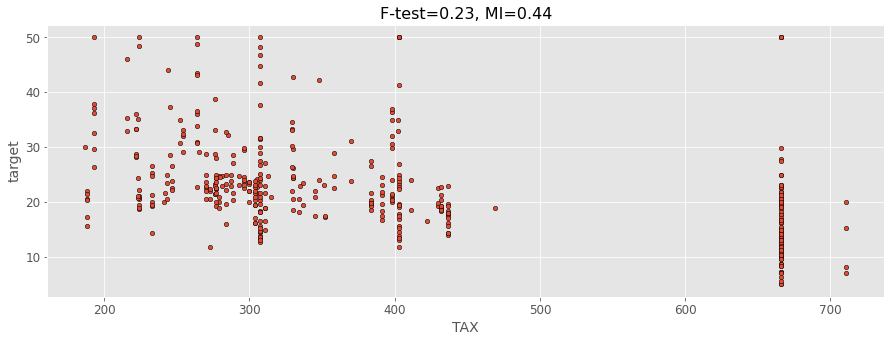

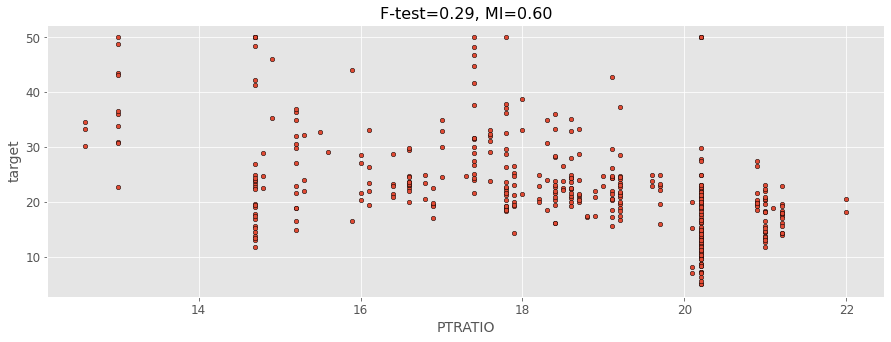

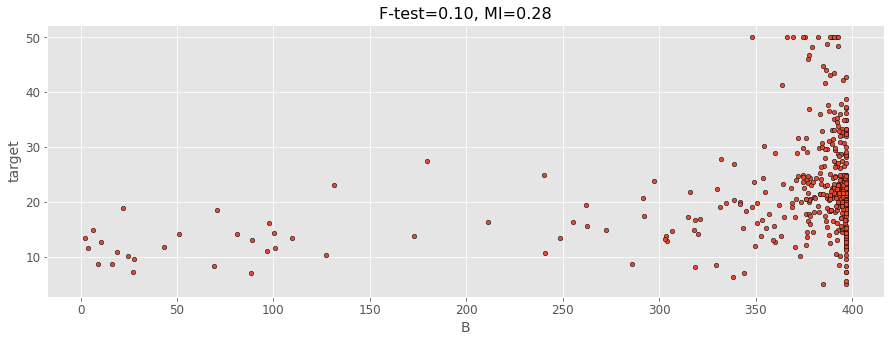

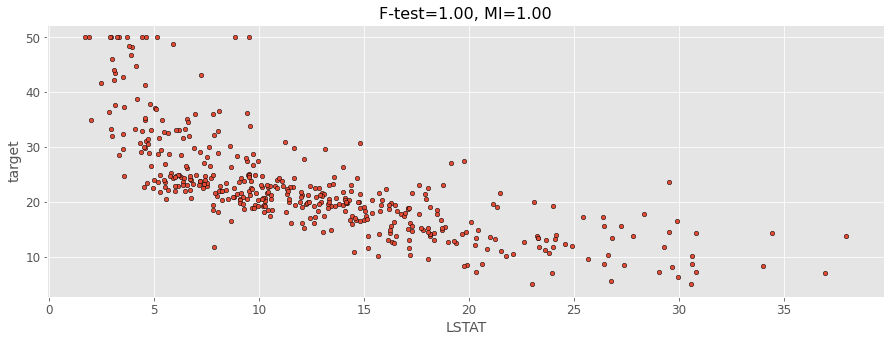

In [12]:
for nm_y in nm_targets:
  f_test, _ = f_regression(trainVal[nm_features], trainVal[nm_y])
  f_test /= np.max(f_test)

  mi = mutual_info_regression(trainVal[nm_features], trainVal[nm_y])
  mi /= np.max(mi)

  # plt.figure(figsize=(15, 5))
  for i in range(len(nm_features)):
      # plt.subplot(len(nm_features), 1, i + 1)
      plt.figure(figsize=(15, 5))
      plt.scatter(trainVal[nm_features[i]], trainVal[nm_y], edgecolor='black', s=20)
      plt.xlabel(nm_features[i], fontsize=14)
      plt.ylabel(nm_y, fontsize=14)
      plt.title("F-test={:.2f}, MI={:.2f}".format(f_test[i], mi[i]),
                fontsize=16)
      plt.show()

# Preprocessing Data

## Scaler and PCA
Dimensionality reduction with method ['mle'](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) proposed by Minka, in paper [Automatic choice of dimensionality for PCA ](https://papers.nips.cc/paper/2000/file/7503cfacd12053d309b6bed5c89de212-Paper.pdf).

In [57]:
# Scaler e PCA
pipre = Pipeline([('scaler',preprocessing.RobustScaler()),
                 ('pca',decomposition.PCA(n_components='mle',random_state=seed)) 
                 ])

pipre.fit(train[nm_features])

Pipeline(memory=None,
         steps=[('scaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components='mle',
                     random_state=9, svd_solver='auto', tol=0.0,
                     whiten=False))],
         verbose=False)

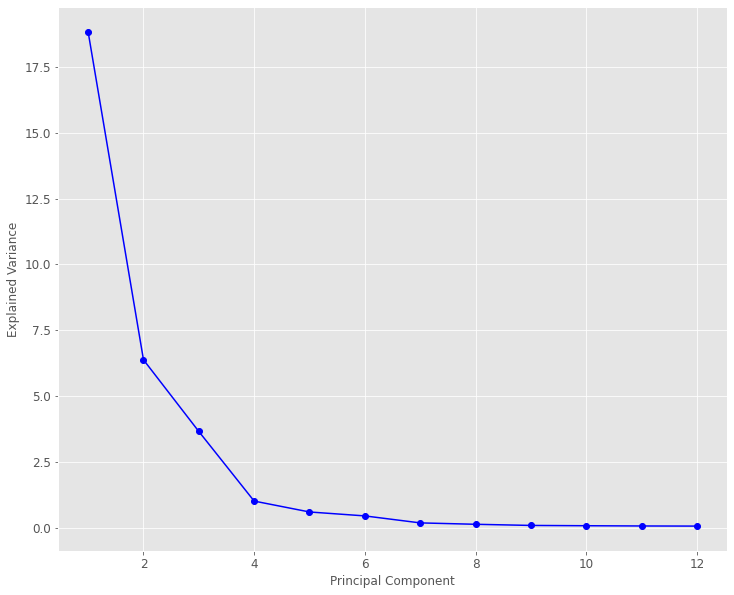

In [45]:
plt.plot(np.arange(1,13),pipre['pca'].explained_variance_, 'b-o')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")
plt.show()

Just little test using only 4 principal components

In [58]:
pipre4comps = Pipeline([('scaler',preprocessing.RobustScaler()),
                        ('pca',decomposition.PCA(n_components=4,random_state=seed)) 
                        ])
pipre4comps.fit(train[nm_features])

Pipeline(memory=None,
         steps=[('scaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=4,
                     random_state=9, svd_solver='auto', tol=0.0,
                     whiten=False))],
         verbose=False)

# Models

## Iterative Models

In [49]:
gtreeboost = ensemble.GradientBoostingRegressor(n_estimators=100,        
                                                validation_fraction= 0.1,
                                                loss='lad',
                                                n_iter_no_change= 10, 
                                                tol= 0.01,
                                                random_state= seed,
                                                verbose = 0)

In [68]:
# Find Best Number of trees
gbest = GetBestNTrees(x_train = pipre.transform(train[nm_features]),
                      y_train = train[nm_targets[0]],
                      x_val = pipre.transform(validation[nm_features]),
                      y_val = validation[nm_targets[0]],
                      estimator = gtreeboost,
                      min_trees = 50, max_trees = 2000,
                      step = 10,
                      n_error_up = 500
                      )
gbest

[480,
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                           init=None, learning_rate=0.1, loss='lad', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=480,
                           n_iter_no_change=10, presort='deprecated',
                           random_state=9, subsample=1.0, tol=0.01,
                           validation_fraction=0.1, verbose=0, warm_start=True)]

## Building Pipeline and Grid Search

In [70]:
pipe = Pipeline(steps=[('pre_processing',pipre),
                       ('regressor', RANSACRegressor(random_state=seed))
                       ]
                )

# Create space of candidate learning algorithms and their hyperparameters
search_space = [{'regressor': [RANSACRegressor(random_state=seed)],
                'regressor__loss': ['absolute_loss','squared_loss']
                },
                {'regressor': [LinearRegression(n_jobs=-1)]
                },
                {'regressor':[ensemble.GradientBoostingRegressor(n_estimators=gbest[0],        
                                                                validation_fraction= 0.1,
                                                                loss='lad',
                                                                n_iter_no_change= 10, 
                                                                tol= 0.01,
                                                                random_state= seed,verbose = 0)]
                }
                ]

grid_model = GridSearchCV(estimator = pipe,
                          param_grid = search_space, 
                          scoring = 'neg_median_absolute_error' ,
                          cv=5, verbose = True, n_jobs=-1)

Model Fit

In [71]:
grid_model.fit(trainVal[nm_features], 
               trainVal[nm_targets[0]])

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.5s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pre_processing',
                                        Pipeline(memory=None,
                                                 steps=[('scaler',
                                                         RobustScaler(copy=True,
                                                                      quantile_range=(25.0,
                                                                                      75.0),
                                                                      with_centering=True,
                                                                      with_scaling=True)),
                                                        ('pca',
                                                         PCA(copy=True,
                                                             iterated_power='auto',
                                                             n_c

### Best Estimator Pipeline

In [75]:
grid_model.best_estimator_

Pipeline(memory=None,
         steps=[('pre_processing',
                 Pipeline(memory=None,
                          steps=[('scaler',
                                  RobustScaler(copy=True,
                                               quantile_range=(25.0, 75.0),
                                               with_centering=True,
                                               with_scaling=True)),
                                 ('pca',
                                  PCA(copy=True, iterated_power='auto',
                                      n_components='mle', random_state=9,
                                      svd_solver='auto', tol=0.0,
                                      whiten=False))],
                          verbose=False)),
                ('regressor',
                 GradientBoostingRegressor(al...
                                           learning_rate=0.1, loss='lad',
                                           max_depth=3, max_features=None,
           

### All Scores

In [84]:
boston['target'].describe()

count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: target, dtype: float64

In [81]:
grid_model.cv_results_['mean_test_score']

array([-2.87625019, -3.30190545, -2.57606588, -2.07837875])